# Toy Radix Lagrangean decomposition validation

In [1]:
REG_WEIGHT   = 0. #1e-4
MAX_NONZERO  = None #48*2
PREVENT_ZERO = True
POWERS       = [-1,0,1] #[-2,-1,0,1,2]
TWO_PHASE    = True

In [2]:
%load_ext line_profiler

In [3]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [4]:
ijomc = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')

In [5]:
ijomc.optimize()
mu_crowd0 = ijomc.reactions.BIOMASS_Ecoli_core_w_GAM.x
print(mu_crowd0)

0.873921506968


In [6]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

ex_rxns = [r for r in df_meas.ex_rxn.unique() if ijomc.reactions.has_id(r)]
df_meas = df_meas[ df_meas.ex_rxn.isin(ex_rxns)]
conds = df_meas.substrate.unique()

#N_CONDS = len(conds)
N_CONDS = 3

df_conds = pd.DataFrame([{'cond':r['substrate'], 'rxn':ex_rxn, 'lb':-10 if r['ex_rxn']==ex_rxn else 0, 'ub':1000., 'obj':0.} for i,r in df_meas.iterrows() for ex_rxn in ex_rxns])

if N_CONDS==1:
    df_conds = df_conds[ df_conds.cond=='acetate']
elif N_CONDS<=3:
    df_conds = df_conds[ df_conds.cond.isin(['glucose','acetate','succinate'][0:N_CONDS])]
else:
    df_conds = df_conds[ df_conds.cond.isin(conds[0:N_CONDS])]

df_conds.loc[ (df_conds.cond=='acetate') & (df_conds.rxn=='EX_ac_e'), 'lb'] = -20

# Make radix problem

In [7]:
from dynamicme.estimate import RadixEstimator

In [8]:
df_Y = df_meas.rename(columns={'growth_rate_1_h':'output', 'substrate':'cond'})
df_Y.loc[:,'output_id'] = 'BIOMASS_Ecoli_core_w_GAM'
df_X = df_conds

In [9]:
est = RadixEstimator()
est.fit(ijomc, df_X, df_Y, reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False,
       powers=POWERS)

est.milp.Params.ScaleFlag = 0
est.milp.Params.OutputFlag = 1
est.milp.Params.TimeLimit = 2*3600.
# est.milp.Params.Presolve = 0
# est.milp.Params.FeasibilityTol = 1e-8
# est.milp.Params.OptimalityTol = 1e-8

# est.optimize()

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter ScaleFlag to 0
   Prev: -1  Min: -1  Max: 3  Default: -1
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TimeLimit to 7200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100


## Validate the fit

base_model = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')

mu_id = 'BIOMASS_Ecoli_core_w_GAM'
df_pred = est.predict(df_X, base_model, meas_id=mu_id)

df_Y2 = df_Y[[c for c in df_Y.columns if c not in ['order','ex_rxn']]]
df_val = pd.merge(df_Y2.rename(columns={'output':'meas'}), df_pred.rename(columns={'rxn':'output_id','x':'pred'}), on=['cond','output_id'])
df_val.loc[:,'error'] = (df_val.pred - df_val.meas)
df_val.loc[:,'perror'] = df_val.error / df_val.meas * 100
df_val

a0 = 1./65/3600
kfit_dict0 = {k:a0 for k in est.kfit_dict.keys()}
df_ref = est.predict(df_X, base_model, meas_id=mu_id, kfit_dict=kfit_dict0)
df_ref.rename(columns={'rxn':'output_id','x':'output'}, inplace=True)

df_val0 = pd.merge(df_Y2.rename(columns={'output':'meas'}), df_ref.rename(columns={'output':'pred0'}), on=['cond','output_id'])
df_val0.loc[:,'error0'] = (df_val0.pred0 - df_val0.meas)
df_val0.loc[:,'perror0'] = df_val0.error0 / df_val0.meas * 100

df_comp = pd.merge(df_val, df_val0, on=['cond','output_id','meas'])
df_comp.loc[:,'error_change'] = (df_comp.error.abs()-df_comp.error0.abs()) / df_comp.error0.abs() * 100
df_comp

print('Total abs error: %g' % df_comp.error.abs().sum())
print('Total perc error: %g%%' % df_comp.perror.abs().sum())
print('Total error change: %g%%' % df_comp.error_change.sum())
changed = [abs(est.kfit_dict[k]-kfit_dict0[k])>1e-9 for k in est.kfit_dict.keys()]
print('Number of keffs changed: %d/%d (%g%%)' % (sum(changed),len(est.kfit_dict), 100*sum(changed)/len(est.kfit_dict) ))

# Each Lagrange submodel should start with the optimum

In [10]:
from dynamicme.decomposition import LagrangeMaster, LagrangeSubmodel

In [11]:
conds = df_conds.cond.unique()
sub_dict = {}
for cond in conds:
    df_Xk = df_X[ df_X.cond==cond]
    df_Yk = df_Y[ df_Y.cond==cond]
    estk = RadixEstimator()
    estk.fit(ijomc, df_Xk, df_Yk, reg_weight = REG_WEIGHT, max_nonzero_binaries=MAX_NONZERO, optimize=False,
            powers=POWERS)
    sub = LagrangeSubmodel(estk.stacker.model, cond)
    sub_dict[cond] = sub

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


In [12]:
master = LagrangeMaster(estk.stacker.model)
master.add_submodels(sub_dict)

In [13]:
for sub in sub_dict.values():
    sub.model.Params.MIPGapAbs = 1e-3
    sub.model.Params.MIPGap    = 1e-3

In [14]:
is_bin = [y.upper_bound<=1 for y in master._y0]
np.all(is_bin)

True

In [15]:
from scipy.sparse import identity
identity(3)

<3x3 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements (1 diagonals) in DIAgonal format>

In [16]:
sub._weight

1.0

### Two-phase

In [17]:
master.time_limit = 2*3600
#master.max_iter = 500
master.verbosity = 2
master.print_iter = 5
# master.gaptol = 0.02
master.gaptol = 1e-3
master.absgaptol = 1e-3
feasible_method = 'enumerate'
alt_method = 'pool'
max_alt = 10    # Computationally expensive if too large. Might miss feasible solution if too small.
                # Can make adaptive if no feasible solution found for certain iterations.

if TWO_PHASE:
    sol_master = master.solve_relaxed(feasible_method=None)
    df_phase1 = pd.DataFrame(master.log_rows)
    
sol_master = master.optimize(feasible_method=feasible_method, max_alt=max_alt, alt_method=alt_method,
                            nogood_cuts = True) 
df_phase2 = pd.DataFrame(master.log_rows)

    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
       0       1000     1e+100    0.04277    0.04277      1000       100         0  0.067291  0.003162  0.062505
       5     0.9683     1e+100     -46.14    0.04277    0.9255     95.58     0.961  0.225882  0.001158  0.034387
      10     0.2411     1e+100     -94.16    0.04277    0.1983     82.26     0.115  0.390470  0.001918  0.029300
      15     0.1184     1e+100     -363.8    0.04277   0.07566     63.89    0.0409  0.534291  0.003398  0.022799
      20    0.05347     1e+100     -616.3    0.04277   0.01071     20.02   0.00532  0.683790  0.003949  0.027906
      25     0.0481     1e+100     -759.3    0.04277  0.005338      11.1  0.000356  0.838370  0.

/home/laurence/python_modules/dynamicme.git/dynamicme/decomposition.py:2136 UserWarning: Solution available but Master solver status=suboptimal (13).



    Iter                    UB                    LB       gap relgap(%)   penalty                       Time(s)
  ------   -------------------   -------------------  -------- ---------  -------- -----------------------------
               Best   Feasible        Sub       Best                                   total    master       sub
Master solver status=suboptimal (13).
       0    0.04294     1e+100   -0.03593   -0.03593   0.07887     183.7  9.17e-05  0.490434  0.110406  0.379333
Master solver status=suboptimal (13).
Master solver status=suboptimal (13).
Master solver status=suboptimal (13).
Master solver status=suboptimal (13).
Master solver status=suboptimal (13).
       5    0.04265     1e+100    0.02822    0.03966   0.00299      7.01  2.88e-06  2.875734  0.219770  0.315162
Master solver status=suboptimal (13).
       6    0.04274     1e+100    0.04226    0.04226         0         0  4.77e-07  3.204508  0.267597  0.060518
Excluded 1 infeasible alt optima
Excluded 1 infeasible 

In [24]:
len(master._us)

144

In [18]:
df_phase1.t_total.max() + df_phase2.t_total.max()

100.6982102394104

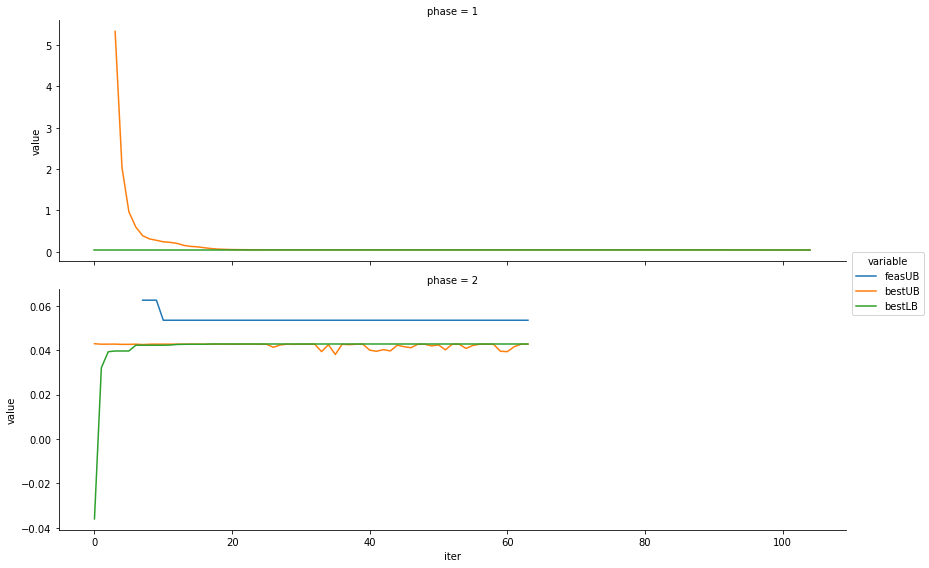

In [19]:
xcol = 'iter'
df_phase1.loc[:,'phase'] = 1
df_phase2.loc[:,'phase'] = 2
dsplot = pd.concat([df_phase1, df_phase2])
dsplot = dsplot[[xcol,'feasUB','bestUB','bestLB','phase']]
dsplot = dsplot.melt(id_vars=[xcol,'phase'])
dsplot.loc[ dsplot.value>1e1, 'value'] = np.nan
dsplot.loc[ dsplot.value<-1e1, 'value'] = np.nan

g = sns.FacetGrid(dsplot, hue='variable', size=4, aspect=3, row='phase', sharey=False)
g.map(plt.plot, xcol,'value')
g.add_legend()

In [20]:
var_cons_dict = estk.var_cons_dict
powers = estk.powers
digits = estk.digits
radix  = estk.radix

In [21]:
kfit_dict = {}
for group_id, var_dict in iteritems(var_cons_dict):
    var = var_dict[0]
    cons = var_dict[1]
    a0  = var_dict[0][2]
    kfit = 0.
    for l,pwr in enumerate(powers):
        for k,digit in enumerate(digits):            
            yid = 'binary_%s%s%s' % (group_id,k,l)
            y   = sol_master[yid]
#             y   = sol_masterk[yid]
            kfit += y*a0*radix**pwr*digit
    kfit_dict[group_id] = kfit

kfit_changed = [(k,v, abs(v-a0)/a0) for k,v in iteritems(kfit_dict) if abs(v-a0)/a0>1e-6]
print('Changed keffs: %d/%d' % (len(kfit_changed), len(var_cons_dict)))
#----------------------------------------
# Starting from basal model
perrs = []
errs_fit = []
errs_unfit = []
csrcs = df_conds.cond.unique()
for csrc in csrcs:    
    ijofit = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')
    crowding = ijofit.metabolites.get_by_id('crowding')
    df_condi = df_conds[ df_conds.cond==csrc]    
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']

    for rid,kfit in iteritems(kfit_dict):
        rxn = ijofit.reactions.get_by_id(rid)
        rxn.add_metabolites({crowding:kfit}, combine=False)
    
    ijofit.optimize()
    
    mu_measi = df_meas[ df_meas.substrate==csrc].growth_rate_1_h.iloc[0]
    mu_fiti = ijofit.reactions.BIOMASS_Ecoli_core_w_GAM.x
    
    # Get unfit
    for rxn in ijofit.metabolites.crowding.reactions:
        rxn._metabolites[crowding] = a0
    ijofit.optimize()
    mu_unfiti = ijofit.reactions.BIOMASS_Ecoli_core_w_GAM.x
    err0= 100*(mu_unfiti-mu_measi)/mu_measi
    err = 100*(mu_fiti - mu_measi)/mu_measi
    derr= 100*(abs(err)-abs(err0))/abs(err0)
    perrs.append(err)
    errs_unfit.append(mu_unfiti - mu_measi)
    errs_fit.append(mu_fiti - mu_measi)
    print('Cond=%s. mu_meas=%g. mu_sim=%g (unfit=%g, error=%.3g%%). Error=%.3g%% (%.3g%% change)' % (
        csrc, mu_measi, mu_fiti, mu_unfiti, err0, err, derr))
    for i,row in df_condi.iterrows():
        rid = row['rxn']
        rxn = ijofit.reactions.get_by_id(rid)        
        print('\t%s uptake=%g' % (rxn.id, rxn.x))
perrs = np.array(perrs)
errs_fit = np.array(errs_fit)
errs_unfit = np.array(errs_unfit)
tot_err = sum(abs(errs_fit))
tot_err0 = sum(abs(errs_unfit))
print("Absolute total error: %g"%(tot_err))
print("Total error change: %g%%"%( 100*(tot_err-tot_err0)/tot_err0  ))
print("Absolute percent error: %g%% -- %g%%"%(min(abs(perrs)), max(abs(perrs))))
print("Mean abs percent error = %g%%"%(np.mean(abs(perrs))))
print("Median abs percent error = %g%%"%(np.median(abs(perrs))))

Changed keffs: 44/48
Cond=glucose. mu_meas=0.74. mu_sim=0.740001 (unfit=0.873922, error=18.1%). Error=0.000109% (-100% change)
	EX_glc__D_e uptake=-10
	EX_fru_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_ac_e uptake=0
Cond=succinate. mu_meas=0.46. mu_sim=0.397563 (unfit=0.397563, error=-13.6%). Error=-13.6% (-1.32e-10% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=0
	EX_succ_e uptake=-10
	EX_mal__L_e uptake=0
	EX_ac_e uptake=0
Cond=acetate. mu_meas=0.256. mu_sim=0.256273 (unfit=0.389313, error=52.1%). Error=0.107% (-99.8% change)
	EX_glc__D_e uptake=0
	EX_fru_e uptake=0
	EX_succ_e uptake=0
	EX_mal__L_e uptake=0
	EX_ac_e uptake=-20
Absolute total error: 0.0627106
Total error change: -80.9778%
Absolute percent error: 0.000109479% -- 13.5733%
Mean abs percent error = 4.55998%
Median abs percent error = 0.106578%


## Confirm that all ys the same

In [22]:
y_sames = []
for y in sub._ys:
    sub1 = sub_dict['acetate']
    sub2 = sub_dict['glucose']
    y1 = sub1.x_dict[y.VarName]
    y2 = sub2.x_dict[y.VarName]
    y_sames.append(abs(y1-y2)<1e-10)
    print('%12.10s%12.10s%12.10s%12.10s'%(y.VarName,y1,y2, abs(y1-y2)<1e-10))    

  binary_G6P         0.0         0.0        True
  binary_G6P         1.0         1.0        True
  binary_G6P         1.0         1.0        True
  binary_AKG         1.0         1.0        True
  binary_AKG         0.0         0.0        True
  binary_AKG         1.0         1.0        True
  binary_ME2         1.0         1.0        True
  binary_ME2         0.0         0.0        True
  binary_ME2         0.0         0.0        True
  binary_MAL         1.0         1.0        True
  binary_MAL         0.0         0.0        True
  binary_MAL         0.0         0.0        True
  binary_GLU         0.0         0.0        True
  binary_GLU         1.0         1.0        True
  binary_GLU         0.0         0.0        True
  binary_ME1         0.0         0.0        True
  binary_ME1         0.0         0.0        True
  binary_ME1         1.0         1.0        True
  binary_PGI         0.0         0.0        True
  binary_PGI         1.0         1.0        True
  binary_PGI        

In [23]:
print('num same = %s/%s'%(sum(y_sames), len(y_sames)))

num same = 144/144
